<a href="https://colab.research.google.com/github/mtajilrou/whaly/blob/master/Humback_Wales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function

import os
import csv
from shutil import copyfile

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.13.1


##Install Kaggle API and make a directory called kaggle


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

##import API into colab

In [0]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mtajilrou","key":"d891a7d0473961f2fca7bce9b8e36212"}'}

##copy API key to kaggle directory

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##Download the dataset

In [0]:
!kaggle competitions download -c humpback-whale-identification

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile

full_train_dir = "/content/whales/train/"


zip_ref = zipfile.ZipFile("/content/train.zip", "r")
zip_ref.extractall(path=full_train_dir)
zip_ref.close()




Extract a subset of the training data for the 31 whales that have the most number of samples

In [0]:
train_dir_path ="/content/train_new"
validation_dir_path ="/content/test_new"

myids = ['w_23a388d',
'w_9b5109b',
'w_9c506f6',
'w_0369a5c',
'w_700ebb4',
'w_3de579a',
'w_564a34b',
'w_fd3e556',
'w_88e4537',
'w_2b069ba',
'w_d405854',
'w_789c969',
'w_f0fe284',
'w_343f088',
'w_5e8e218',
'w_778e474',
'w_5a2634c',
'w_60ce6fc',
'w_a9304b9',
'w_6822dbc',
'w_af367c3',
'w_1ca9ab1',
'w_f765256',
'w_17b0d3a',
'w_d72771c',
'w_08630fd',
'w_6cda039',
'w_8c25681',
'w_04003e9',
'w_51fc1fc',
'w_fd6a3ad']

os.mkdir(full_train_dir_path)
os.mkdir(test_dir_path)

for wid in myids:
    # create a folder for this whale in the training set
    path = os.path.join(full_train_dir_path,wid)
    os.mkdir(path)

    # create a folder for this whale in the test set
    path = os.path.join(test_dir_path,wid)
    os.mkdir(path)

FileExistsError: ignored

In [0]:
with open('/content/train.csv', 'r') as f:
    reader= csv.reader(f)
    for row in reader:
        if row[1] in myids:
            src = os.path.join(full_train_dir, row[0])
            dst = os.path.join(train_dir_path,row[1], row[0])
            
            copyfile(src, dst)

In [0]:
with open('/content/train.csv', 'r') as f:
    reader= csv.reader(f)
    for row in reader:
        if row[1] in myids:
            src = os.path.join(full_train_dir, row[0])
            dst = os.path.join(validation_dir_path,row[1], row[0])
            
            copyfile(src, dst)

FileNotFoundError: ignored

# Now, Let's do the training

In [0]:
image_size = 160 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir_path,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir_path, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 0 images belonging to 0 classes.


FileNotFoundError: ignored

## Get a base model

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
9412608/9406464 [==============================] - 0s 0us/step


## Create a new model using the base model

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(len(myids), activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                39711     
Total params: 2,297,695
Trainable params: 2,263,583
Non-trainable params: 34,112
_________________________________________________________________


## Train the model

In [0]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/10
42/42 [==============================] - 486s 12s/step - loss: 3.0878 - acc: 0.2332 - val_loss: 2.9925 - val_acc: 0.1849
Epoch 2/10
42/42 [==============================] - 467s 11s/step - loss: 2.0884 - acc: 0.7479 - val_loss: 2.4543 - val_acc: 0.3328
Epoch 3/10
42/42 [==============================] - 463s 11s/step - loss: 1.1636 - acc: 0.9057 - val_loss: 2.0721 - val_acc: 0.4136
Epoch 4/10
42/42 [==============================] - 464s 11s/step - loss: 0.5246 - acc: 0.9811 - val_loss: 1.8027 - val_acc: 0.4740
Epoch 5/10
42/42 [==============================] - 459s 11s/step - loss: 0.2092 - acc: 0.9940 - val_loss: 1.7517 - val_acc: 0.4936
Epoch 6/10
42/42 [==============================] - 451s 11s/step - loss: 0.0873 - acc: 0.9985 - val_loss: 1.4447 - val_acc: 0.6060
Epoch 7/10
42/42 [==============================] - 454s 11s/step - loss: 0.0353 - acc: 0.9992 - val_loss: 1.1736 - val_acc: 0.6830
Epoch 8/10
42/42 [==============================] - 453s 11s/step - loss: 0.

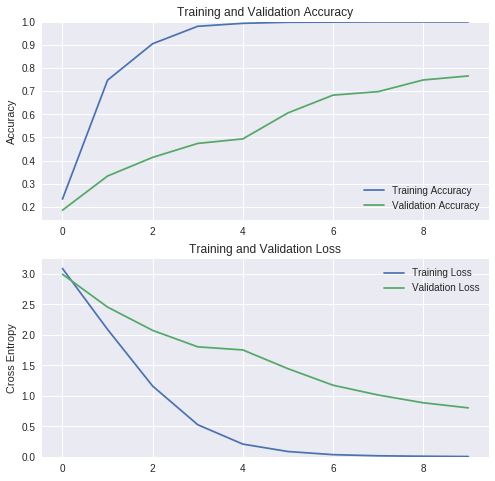

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()